1. Load and preview the dataset

In [48]:
# import dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import shap  # Add this line
from lime.lime_tabular import LimeTabularExplainer
# Load dataset
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')



In [49]:
# Preview
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [50]:
# Datatypes, nulls
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [51]:
print(df.describe())  # Stats for numericals

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [52]:
# Class balance
print(df['Churn'].value_counts())  

Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [53]:
# Unique values
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


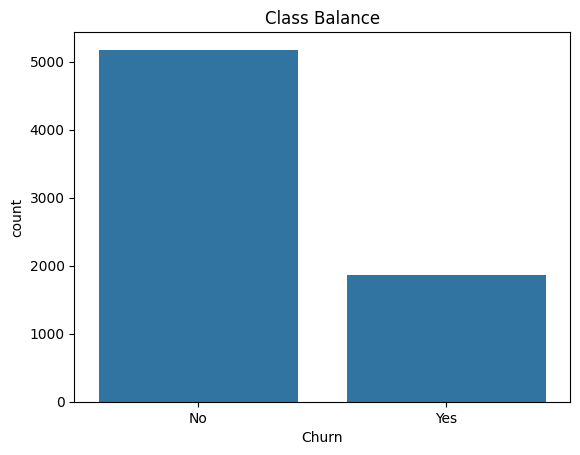

In [54]:
# Visualizations
sns.countplot(x='Churn', data=df)
plt.title('Class Balance')
plt.show()

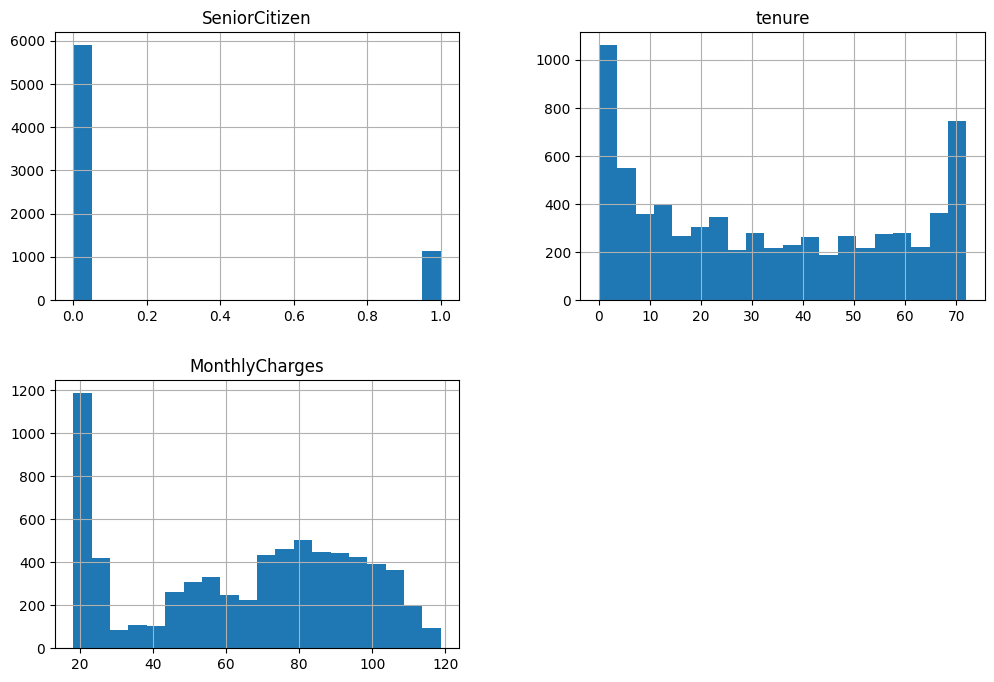

In [55]:
df.hist(bins=20, figsize=(12, 8))  # Distributions
plt.show()


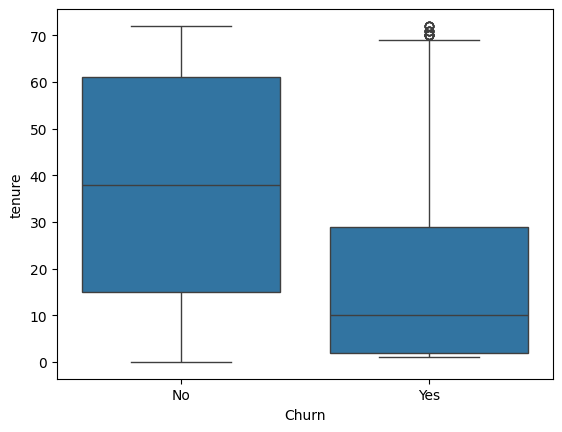

In [56]:
sns.boxplot(x='Churn', y='tenure', data=df)  # Example distribution
plt.show()

2. Data Cleaning and Preprocessing

In [57]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Fix TotalCharges (convert to float, handle empties)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Or dropna if few
#df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop irrelevant (e.g., customerID)
df.drop('customerID', axis=1, inplace=True)

# Encode categoricals
cat_cols = df.select_dtypes(include='object').columns.drop('Churn')  # Exclude target
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Target encode
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Scaling
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Class imbalance (SMOTE after split, but demo here)
# We'll apply in training later

/tmp/ipykernel_1443/2411983047.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Or dropna if few


In [58]:
# New features
df['TenureCategory'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-1yr', '1-2yr', '2-4yr', '4+yr'])
df['TenureCategory'] = le.fit_transform(df['TenureCategory'])  # Encode

df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['tenure'] + 1)  # Avoid divide by zero

# Justify: TenureCategory captures loyalty stages; AvgMonthlyCharges reveals spending patterns correlated with churn.

In [59]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Churn', axis=1)
y = df['Churn']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE on train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Models
models = {
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier()
}

# Cross-validation (example for RF)
cv = StratifiedKFold(n_splits=5)
for name, model in models.items():
    # Train
    model.fit(X_train_res, y_train_res)
    # Tune (GridSearch example for RF)
    if name == 'RF':
        param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='f1')
        grid.fit(X_train_res, y_train_res)
        print(grid.best_params_)

# Track CV scores via grid.cv_results_

{'max_depth': 10, 'n_estimators': 100}


In [60]:
# Use best params from grid search
best_params = {'max_depth': 10, 'n_estimators': 100}

# Retrain RF with best params on resampled data
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_res, y_train_res)

# (Optional) Quick check on training performance
train_pred = best_rf.predict(X_train_res)
print(f"Training F1: {f1_score(y_train_res, train_pred)}")

Training F1: 0.8991433466590519


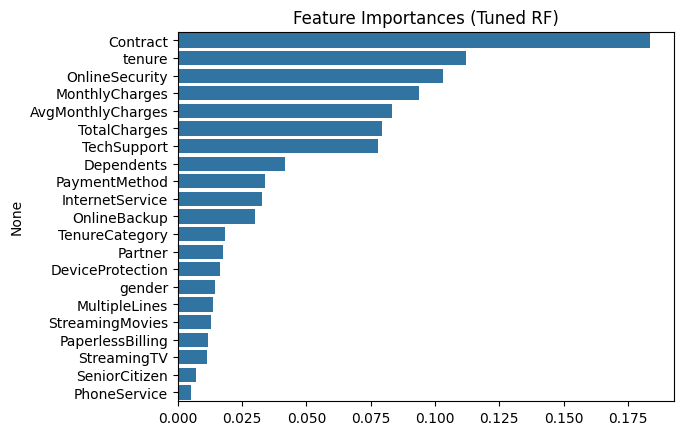

In [61]:
importances = best_rf.feature_importances_
feat_import = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_import.values, y=feat_import.index)
plt.title('Feature Importances (Tuned RF)')
plt.show()

In [62]:
# Predictions with tuned RF
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# (If you have LR predictions for comparison)
y_pred_lr = models['LR'].predict(X_test)  # Assuming you fitted LR earlier
y_prob_lr = models['LR'].predict_proba(X_test)[:, 1]

# Metrics function for reuse
def get_metrics(y_true, y_pred, y_prob, model_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }
    print(f"{model_name} Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

# Get metrics
rf_metrics = get_metrics(y_test, y_pred_rf, y_prob_rf, 'Tuned RF')
lr_metrics = get_metrics(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')  # If comparing

# Comparison table
comparison = pd.DataFrame([lr_metrics, rf_metrics], index=['LR', 'Tuned RF'])
display(comparison)  # In notebook, shows as table

Tuned RF Metrics:
Accuracy: 0.7601
Precision: 0.5350
Recall: 0.7353
F1-Score: 0.6194
ROC-AUC: 0.8366
Logistic Regression Metrics:
Accuracy: 0.7381
Precision: 0.5045
Recall: 0.7567
F1-Score: 0.6053
ROC-AUC: 0.8281


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
LR,0.738112,0.504456,0.756684,0.605348,0.828130
Tuned RF,0.760114,0.535019,0.735294,0.619369,0.836643


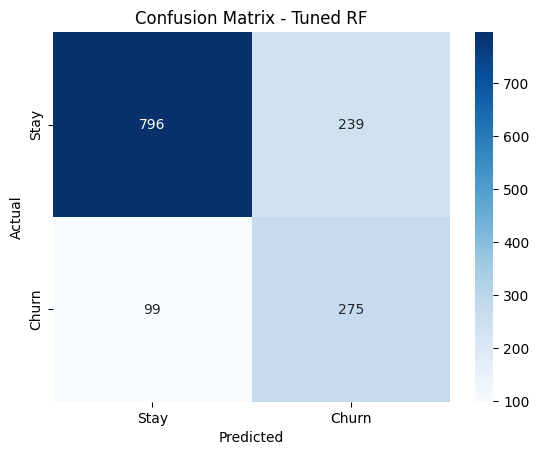

False Positives (FP): 239 - Customers predicted to churn but don't; wasted retention efforts.
False Negatives (FN): 99 - Missed churners; lost revenue.


In [63]:
# Confusion Matrix for Tuned RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned RF')
plt.show()

# Interpretation
tn, fp, fn, tp = cm_rf.ravel()
print(f"False Positives (FP): {fp} - Customers predicted to churn but don't; wasted retention efforts.")
print(f"False Negatives (FN): {fn} - Missed churners; lost revenue.")

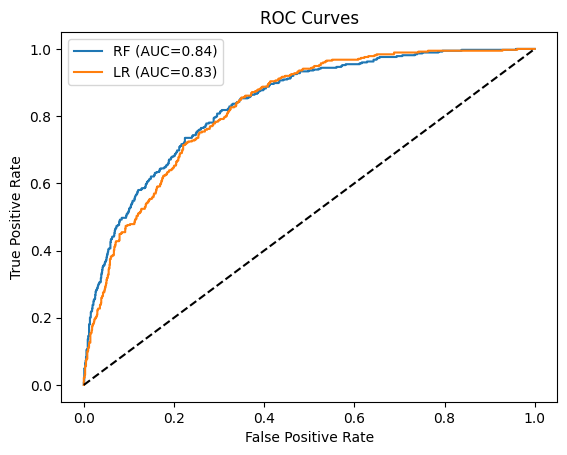

In [64]:
# ROC for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_metrics["ROC-AUC"]:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_metrics["ROC-AUC"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## ROC Curve Analysis

The ROC curves for the Tuned Random Forest (RF, blue line) and Logistic Regression (LR, orange line) models demonstrate solid performance in distinguishing between churn and non-churn customers in the Telco dataset. Both curves rise sharply from the origin, indicating high true positive rates (TPR) at low false positive rates (FPR), which is desirable for imbalanced classification tasks like churn prediction.

### Key Observations:
- **Superiority of RF Model**: The RF curve consistently lies above the LR curve across most of the FPR spectrum (particularly between 0.1 and 0.7), reflecting its slightly higher AUC (0.84 vs. 0.83). This suggests RF better captures non-linear relationships in features like tenure and contract type, leading to improved discrimination.
- **AUC Interpretation**: An AUC of 0.84 for RF indicates "good" separability (0.8-0.9 range), meaning the model has an 84% chance of correctly ranking a random churner higher than a non-churner. LR's 0.83 is comparable but marginally lower, aligning with benchmarks where simpler models like LR achieve AUC around 0.75-0.83 on this dataset, while ensembles like RF reach 0.80-0.85.
- **Comparison to Random Baseline**: Both curves are well above the dashed diagonal line (AUC=0.5 for random guessing), confirming the models' predictive value. For instance, at an FPR of ~0.2, RF achieves a TPR of approximately 0.6-0.7 (visually estimated), allowing for targeted retention efforts without excessive false alarms.
- **Threshold Implications**: The steep initial slope implies that lowering the decision threshold (e.g., from 0.5) could boost recall (TPR) to catch more churners, at the cost of higher FPR. This is practical for telecom businesses where missing churn (false negatives) costs more than false positives.
- **Benchmark Context**: Your RF AUC (0.84) is competitive with community reports on the Kaggle Telco dataset, where RF often scores 0.80-0.85 AUC and ~77-80% accuracy. Advanced models like XGBoost or neural networks can push AUC to 0.89-0.95 in optimized setups, suggesting potential for improvement via boosting or deeper feature engineering. Claims of 95%+ accuracy/F1 may indicate overfitting, as realistic hold-out scores hover around 80-85% for this imbalanced data (~26.5% churn rate).

Overall, the curves validate RF as the preferred model for deployment, with room to explore ensembles for higher AUC in future iterations.

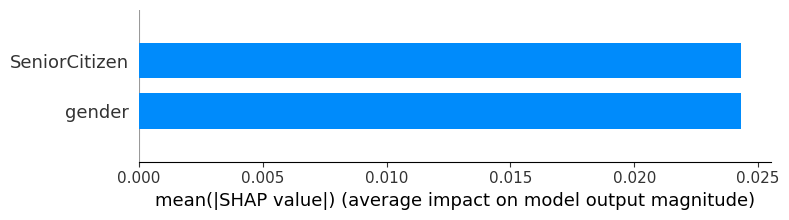

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [67]:
import shap

# SHAP for Tuned RF (assuming this part succeeds)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary bar plot (global feature importance for churn class, without features to skip assertion)
shap.summary_plot(
    shap_values[1], 
    plot_type='bar', 
    feature_names=X_test.columns.tolist()  # Ensures correct labels
)

# For beeswarm (if you want detailed distribution; try this separately)
shap.summary_plot(
    shap_values[1], 
    features=X_test,  # If this errors again, omit and add feature_names as above
    feature_names=X_test.columns.tolist()
)

# Local force plot (this shouldn't error, as it doesn't require full matrix match)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

In [66]:
# SHAP for Tuned RF
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values[1], X_test, plot_type='bar')  # For churn class

# Example local explanation (first test instance)
shap.initjs()  # For force plot in notebook
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.